<a href="https://colab.research.google.com/github/nlei1/nlp-notebooks/blob/main/flair_bert_embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
!pip install flair
import flair
import numpy as np, pandas as pd 
import os
import zipfile
import torch
import string
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy import stats
import gensim
import gensim.downloader as api
import seaborn as sns
import nltk
import matplotlib.pyplot as pyplot
import base64
import requests
import scipy
from flair.embeddings import TransformerWordEmbeddings
from flair.data import Sentence
from flair.embeddings import FlairEmbeddings, TransformerWordEmbeddings
from transformers import AutoTokenizer, AutoModel
nltk.download('punkt')


%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 401 kB 6.2 MB/s 
     |████████████████████████████████| 53 kB 1.8 MB/s 
     |████████████████████████████████| 4.7 MB 20.8 MB/s 
     |████████████████████████████████| 1.6 MB 16.4 MB/s 
     |████████████████████████████████| 788 kB 49.6 MB/s 
     |████████████████████████████████| 981 kB 40.7 MB/s 
     |████████████████████████████████| 1.2 MB 49.1 MB/s 
     |████████████████████████████████| 19.7 MB 1.4 MB/s 
     |████████████████████████████████| 46 kB 1.6 MB/s 
     |████████████████████████████████| 101 kB 7.9 MB/s 
     |████████████████████████████████| 199 kB 41.8 MB/s 
     |████████████████████████████████| 62 kB 1.6 MB/s 
     |████████████████████████████████| 6.6 MB 36.0 MB/s 
     |████████████████████████████████| 596 kB 7.6 MB/s 
  Created wheel for mpld3: filename=mpld3-0.3-py3-none-any.whl size=116702 sha256=ee40adcfc7c6e567

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [8]:
import statistics
import scipy
import torch

biosimlex_url = 'https://raw.githubusercontent.com/cambridgeltl/bio-simverb/master/wvlib/word-similarities/bio-simlex/Bio-SimLex.txt'
biosimverb_url = 'https://raw.githubusercontent.com/cambridgeltl/bio-simverb/master/wvlib/word-similarities/bio-simverb/Bio-SimVerb.txt'
umnsrs_rel_url = 'https://raw.githubusercontent.com/cambridgeltl/bio-simverb/master/wvlib/word-similarities/UMNSRS/UMNSRS-rel.txt'
umnsrs_sim_url = 'https://raw.githubusercontent.com/cambridgeltl/bio-simverb/master/wvlib/word-similarities/UMNSRS/UMNSRS-sim.txt'

In [2]:
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
tokenizer.model_max_length=256
embedding = TransformerWordEmbeddings("emilyalsentzer/Bio_ClinicalBERT",
                                      allow_long_sentences=True,
                                      tokenizer = tokenizer)
embedding.tokenizer.model_max_length=256


In [3]:
cur_model = {}

In [4]:
txt_url1 = 'https://raw.githubusercontent.com/nlei1/csvs-for-proj/main/mtsamples_corpus.txt'
req1 = requests.get(txt_url1)
req1 = (req1.text).lower()

txt_url2 = 'https://raw.githubusercontent.com/nlei1/csvs-for-proj/main/merged_patient_texts.txt'
req2 = requests.get(txt_url2)
req2 = (req2.text).lower()

req = req1 + " " + req2

In [5]:
a_list = nltk.tokenize.sent_tokenize(req)
a_list

[' a 23-year-old white female presents with complaint of allergies.',
 'subjective:,  this 23-year-old white female presents with complaint of allergies.',
 'she used to have allergies when she lived in seattle but she thinks they are worse here.',
 'in the past, she has tried claritin, and zyrtec.',
 'both worked for short time but then seemed to lose effectiveness.',
 'she has used allegra also.',
 'she used that last summer and she began using it again two weeks ago.',
 'it does not appear to be working very well.',
 'she has used over-the-counter sprays but no prescription nasal sprays.',
 'she does have asthma but doest not require daily medication for this and does not think it is flaring up.,medications: , her only medication currently is ortho tri-cyclen and the allegra.,allergies: , she has no known medicine allergies.,objective:,vitals:  weight was 130 pounds and blood pressure 124/78.,heent:  her throat was mildly erythematous without exudate.',
 'nasal mucosa was erythemato

In [24]:
embeddings = TransformerWordEmbeddings("emilyalsentzer/Bio_ClinicalBERT", 
                                       layers='1', 
                                       layer_mean=False,
                                       subtoken_pooling='mean',
                                       allow_long_sentences=True,
                                       tokenizer = tokenizer,)


In [23]:
layer_num=1
embedding = TransformerWordEmbeddings("emilyalsentzer/Bio_ClinicalBERT",
                                      allow_long_sentences=True,
                                      layers=layer_num, 
                                      layer_mean=False,
                                      subtoken_pooling='mean')

AttributeError: ignored

In [25]:
str(1)

'1'

In [28]:
def run_layer(layer_num):
  tensors_dict = {}
  embedding = TransformerWordEmbeddings("emilyalsentzer/Bio_ClinicalBERT",
                                        allow_long_sentences=True,
                                        tokenizer = tokenizer,
                                        layers=str(layer_num), 
                                        layer_mean=False,
                                        subtoken_pooling='mean')
  def extract_word_index(sentence, word):
    return (sentence.lower().split()).index(word.lower()) + 1

  def get_embeddings_for_sentence(s, w):
    sentence = Sentence(s, use_tokenizer=True)
    embedding.embed(sentence)
    return sentence.get_token(extract_word_index(s, w)).embedding

  def get_tensor_tuple_for_drug(drug_name):
    embeddings_lst = []
    counter = 0
    for s in a_list:
      if counter > 10:
        break
      new_s = s.translate(str.maketrans('', '', string.punctuation))
      if f' {drug_name} ' in f' {new_s} ':
        embeddings_lst.append(get_embeddings_for_sentence(new_s, drug_name))
        counter += 1
    return tuple(embeddings_lst)

  def get_pooled_contexts_mean(drug_name):
    print(drug_name)
    return torch.mean(torch.stack(get_tensor_tuple_for_drug(drug_name)), dim=0)

  url  = 'https://raw.githubusercontent.com/nlei1/csvs-for-proj/main/drugs-side-effects3.csv'
  df = pd.read_csv(url, header=None, error_bad_lines=False)
  insomnia_drug_names = df[0].tolist()
  ind_dct = {k: v for v, k in enumerate(insomnia_drug_names)}


  def get_words(drug_name):
    return [incom for incom in df.iloc[ind_dct[drug_name]] if str(incom) != 'nan']

  def get_embeddings(words_lst):
    # takes in a name and returns a lst of embeddings of drug and its related words
    embeddings = []
    for item in words_lst:
      if item not in cur_model:
        cur_model[item] = get_pooled_contexts_mean(item).tolist()
      embeddings.append(cur_model[item])
    return embeddings

  def get_pca(embeddings, n_components):
    pca = PCA(n_components)
    pca_result = pca.fit_transform(embeddings)
    post_pca = pd.DataFrame(pca_result, columns = ['x','y'])
    return post_pca

  def get_tsne(embeddings, p_perplexity, p_n_iter, n_components):
    tsne = TSNE(n_components, perplexity=p_perplexity, n_iter=p_n_iter)
    tsne_result = tsne.fit_transform(embeddings)
    post_tsne = pd.DataFrame(tsne_result, columns = ['x','y'])
    return post_tsne

  def plot_with_labels(drug_name, pca=True, p_perplexity=10000, p_n_iter=100000, n_components=2):
    words_lst = get_words(drug_name)
    print(words_lst)
    new_words_lst = []
    for item in words_lst:
      if f' {item} ' in f' {req} ':
        new_words_lst.append(item)
    print(words_lst)
    
    embeddings_lst = get_embeddings(new_words_lst)
    if pca:
      post_reduction = get_pca(embeddings_lst, n_components)
    else:
      post_reduction = get_tsne(embeddings_lst, p_perplexity, p_n_iter, n_components)
    post_reduction_annotated = post_reduction.join(pd.DataFrame(new_words_lst, columns=['label']))
    title_str = drug_name + (": PCA" if pca else ": TSNE")
    ax = post_reduction_annotated.plot(x='x',y='y',kind='scatter',figsize=(10,10), title=title_str)
    post_reduction_annotated[['x','y','label']].apply(lambda x: ax.text(*x),axis=1)

  def warn(*args, **kwargs):
      pass
  import warnings
  warnings.warn = warn

  def plot_insomnia_drugs():
    for drug in insomnia_drug_names:
      if drug != 'atorvastatin':
        plot_with_labels(drug)
        plot_with_labels(drug, False)

  def get_similarity_table(n=20):
    result_lst = []
    for drug in insomnia_drug_names:
      result_lst.append(pd.DataFrame(model.most_similar(positive=[drug], topn=n), columns=['name (' + drug + ")", 'similarity (' + drug + ")"]))
    return pd.concat(result_lst, axis=1, join="inner")

  def get_effects_table(n=20):
    result_lst = []
    for drug in insomnia_drug_names:
      result_lst.append(pd.DataFrame(model.most_similar(positive=[drug, 'effects'], negative=['medication'], topn=n), columns=['name (' + drug + ")", 'similarity (' + drug + ")"]))
    return pd.concat(result_lst, axis=1, join="inner")

  def forms_of_words_analysis():
    forms_of_words_url = 'https://raw.githubusercontent.com/nlei1/csvs-for-proj/main/forms-of-words.csv'
    forms_of_words_df = pd.read_csv(forms_of_words_url, header=None, error_bad_lines=False)
    word_lst = []
    for index, row in forms_of_words_df.iterrows():
      word_lst += (row.dropna()).tolist()
    new_lst = []
    for thing in word_lst:
      if thing in model.wv.vocab:
        new_lst.append(thing)
    embeddings_lst = get_embeddings(new_lst)
    post_reduction = get_tsne(embeddings_lst, p_perplexity=10000, p_n_iter=10000, n_components=2)
    post_reduction_annotated = post_reduction.join(pd.DataFrame(new_lst, columns=['label']))
    ax = post_reduction_annotated.plot(x='x',y='y',kind='scatter',figsize=(10,10), title='TSNE')
    post_reduction_annotated[['x','y','label']].apply(lambda x: ax.text(*x),axis=1)
    post_reduction = get_pca(embeddings_lst, n_components=2)
    post_reduction_annotated = post_reduction.join(pd.DataFrame(new_lst, columns=['label']))
    ax = post_reduction_annotated.plot(x='x',y='y',kind='scatter',figsize=(10,10), title='PCA')
    post_reduction_annotated[['x','y','label']].apply(lambda x: ax.text(*x),axis=1)

  # Intrinsic Evaluation Methods

  def sim_matrix(a, b, eps=1e-8):
    """
    added eps for numerical stability
    """
    a_n, b_n = a.norm(dim=1)[:, None], b.norm(dim=1)[:, None]
    a_norm = a / torch.max(a_n, eps * torch.ones_like(a_n))
    b_norm = b / torch.max(b_n, eps * torch.ones_like(b_n))
    sim_mt = torch.mm(a_norm, b_norm.transpose(0, 1))
    return sim_mt.item()

  def retrieve_embedding(item, vec_dim=768):
    if item not in tensors_dict:
      tensors_dict[item] = get_pooled_contexts_mean(item)
    return tensors_dict[item].reshape((1, vec_dim))

  def evaluate(filename, num_rows_eval=50): 
    if filename.endswith(".csv"):
      data = (pd.read_csv(filename, sep=",")).iloc[:num_rows_eval]
    else:
      data = pd.read_csv(filename, sep="\t")
    human_similarity = []
    model_similarity = []
    counter = 0
    for i in data.iloc[:, 0:2].index:
      counter += 1
      if counter > num_rows_eval:
        break
      word1, word2 = data.iloc[i, 0], data.iloc[i, 1]
      if not ((f' {word1} ' in f' {req} ') and (f' {word2} ' in f' {req} ')) or " " in word1 or " " in word2:
        continue
      else:
        model_similarity.append(sim_matrix(retrieve_embedding(word1), retrieve_embedding(word2)))
        human_similarity.append(float(data.iloc[i, 2]))

    return scipy.stats.spearmanr(human_similarity, model_similarity)# , model_similarity

  def novel_intrinsic_eval():
    group_a = ["zolpidem","eszopiclone","zaleplon","trazodone","amitriptyline","mirtazapine","doxepin","lorazepam","clonazepam","temazepam","triazolam","suvorexant","lemborexant","melatonin"]
    group_b = ["atorvastatin","acetaminophen","ibuprofen","levothyroxine","lisinopril","metformin","metoprolol","amlodipine","albuterol","omeprazole","losartan","gabapentin","hydrochlorothiazide","furosemide"]
    thetas = []
    for word1 in insomnia_drug_names:
      group1_scores = []
      group2_scores = []
      # group 1: similar
      for word2 in group_a:
        if not ((f' {word1} ' in f' {req} ') and (f' {word2} ' in f' {req} ')):
          # print(word1)
          # print(word2)
          continue
        else:
          group1_scores.append(sim_matrix(retrieve_embedding(word1), retrieve_embedding(word2)))

      # group 2: different
      for word2 in group_b:
        if not ((f' {word1} ' in f' {req} ') and (f' {word2} ' in f' {req} ')):
          # print(word1)
          # print(word2)
          continue
        else:
          group2_scores.append(sim_matrix(retrieve_embedding(word1), retrieve_embedding(word2)))
      
      if group1_scores and group2_scores:
        thetas.append(statistics.median(group1_scores) - statistics.median(group2_scores))
    return statistics.median(thetas)

  def run_eval():
    print(evaluate(biosimlex_url))
    print(evaluate(biosimverb_url))
    print(evaluate(umnsrs_rel_url))
    print(evaluate(umnsrs_sim_url))
    print(novel_intrinsic_eval())

  run_eval()


In [29]:
for i in range(1, 13):
  print("Layer", i)
  run_layer(i)

Layer 1
disorder
disease
tumor
neoplasm
disability
vasculature
assessment
evaluation
likelihood
probability
injection
shot
adhesion
attachment
deviation
displacement
activation
risk
disorientation
nutrition
solution
vector
abundance
worm
replication
doubling
intercourse
sex
eye
globe
vaccination
immunization
infiltration
neonate
vessel
vascularity
excision
removal
physician
doctor
obesity
adiposity
coefficient
distention
ethanol
protection
daughter
etiology
susceptibility
predisposition
prophylaxis
prevention
diathesis
adherence
classification
invasion
SpearmanrResult(correlation=0.8052152823886947, pvalue=1.3824886666947475e-07)
localize
regulate
calibrate
treat
arrest
inhibit
await
equalize
initiate
occur
dissect
stain
block
restrain
label
probe
destabilize
promote
contract
passage
excise
extract
double
replicate
survive
void
suppress
dampen
disclose
study
accumulate
collapse
regain
dilute
ligate
fruit
seed
adhere
attach
coagulate
digest
SpearmanrResult(correlation=0.5814098990608909

In [30]:
layer_1_embedding = TransformerWordEmbeddings("emilyalsentzer/Bio_ClinicalBERT",
                                              allow_long_sentences=True,
                                              tokenizer = tokenizer,
                                              layers=str(layer_num), 
                                              layer_mean=False,
                                              subtoken_pooling='mean')

In [35]:
tensors_dict = {}

def extract_word_index(sentence, word):
  return (sentence.lower().split()).index(word.lower()) + 1

def get_embeddings_for_sentence(s, w):
  sentence = Sentence(s, use_tokenizer=True)
  layer_1_embedding.embed(sentence)
  return sentence.get_token(extract_word_index(s, w)).embedding

def get_tensor_tuple_for_drug(drug_name):
  embeddings_lst = []
  counter = 0
  for s in a_list:
    if counter > 10:
      break
    new_s = s.translate(str.maketrans('', '', string.punctuation))
    if f' {drug_name} ' in f' {new_s} ':
      embeddings_lst.append(get_embeddings_for_sentence(new_s, drug_name))
      counter += 1
  return tuple(embeddings_lst)

def get_pooled_contexts_mean(drug_name):
  print(drug_name)
  return torch.mean(torch.stack(get_tensor_tuple_for_drug(drug_name)), dim=0)

url  = 'https://raw.githubusercontent.com/nlei1/csvs-for-proj/main/drugs-side-effects3.csv'
df = pd.read_csv(url, header=None, error_bad_lines=False)
insomnia_drug_names = df[0].tolist()
ind_dct = {k: v for v, k in enumerate(insomnia_drug_names)}


def get_words(drug_name):
  return [incom for incom in df.iloc[ind_dct[drug_name]] if str(incom) != 'nan']

def get_embeddings(words_lst):
  # takes in a name and returns a lst of embeddings of drug and its related words
  embeddings = []
  for item in words_lst:
    if item not in cur_model:
      cur_model[item] = get_pooled_contexts_mean(item).tolist()
    embeddings.append(cur_model[item])
  return embeddings

def get_pca(embeddings, n_components):
  pca = PCA(n_components)
  pca_result = pca.fit_transform(embeddings)
  post_pca = pd.DataFrame(pca_result, columns = ['x','y'])
  return post_pca

def get_tsne(embeddings, p_perplexity, p_n_iter, n_components):
  tsne = TSNE(n_components, perplexity=p_perplexity, n_iter=p_n_iter)
  tsne_result = tsne.fit_transform(embeddings)
  post_tsne = pd.DataFrame(tsne_result, columns = ['x','y'])
  return post_tsne

def plot_with_labels(drug_name, pca=True, p_perplexity=10000, p_n_iter=100000, n_components=2):
  words_lst = get_words(drug_name)
  print(words_lst)
  new_words_lst = []
  for item in words_lst:
    if f' {item} ' in f' {req} ':
      new_words_lst.append(item)
  print(words_lst)
  
  embeddings_lst = get_embeddings(new_words_lst)
  if pca:
    post_reduction = get_pca(embeddings_lst, n_components)
  else:
    post_reduction = get_tsne(embeddings_lst, p_perplexity, p_n_iter, n_components)
  post_reduction_annotated = post_reduction.join(pd.DataFrame(new_words_lst, columns=['label']))
  title_str = drug_name + (": PCA" if pca else ": TSNE")
  ax = post_reduction_annotated.plot(x='x',y='y',kind='scatter',figsize=(10,10), title=title_str)
  post_reduction_annotated[['x','y','label']].apply(lambda x: ax.text(*x),axis=1)

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

def plot_insomnia_drugs():
  for drug in insomnia_drug_names:
    if drug != 'atorvastatin':
      plot_with_labels(drug)
      plot_with_labels(drug, False)

def get_similarity_table(n=20):
  result_lst = []
  for drug in insomnia_drug_names:
    result_lst.append(pd.DataFrame(model.most_similar(positive=[drug], topn=n), columns=['name (' + drug + ")", 'similarity (' + drug + ")"]))
  return pd.concat(result_lst, axis=1, join="inner")

def get_effects_table(n=20):
  result_lst = []
  for drug in insomnia_drug_names:
    result_lst.append(pd.DataFrame(model.most_similar(positive=[drug, 'effects'], negative=['medication'], topn=n), columns=['name (' + drug + ")", 'similarity (' + drug + ")"]))
  return pd.concat(result_lst, axis=1, join="inner")

def forms_of_words_analysis():
  forms_of_words_url = 'https://raw.githubusercontent.com/nlei1/csvs-for-proj/main/forms-of-words.csv'
  forms_of_words_df = pd.read_csv(forms_of_words_url, header=None, error_bad_lines=False)
  word_lst = []
  for index, row in forms_of_words_df.iterrows():
    word_lst += (row.dropna()).tolist()
  new_lst = []
  for thing in word_lst:
    if f' {thing} ' in f' {req} ':
      new_lst.append(thing)
  embeddings_lst = get_embeddings(new_lst)
  post_reduction = get_tsne(embeddings_lst, p_perplexity=10000, p_n_iter=10000, n_components=2)
  post_reduction_annotated = post_reduction.join(pd.DataFrame(new_lst, columns=['label']))
  ax = post_reduction_annotated.plot(x='x',y='y',kind='scatter',figsize=(10,10), title='TSNE')
  post_reduction_annotated[['x','y','label']].apply(lambda x: ax.text(*x),axis=1)
  post_reduction = get_pca(embeddings_lst, n_components=2)
  post_reduction_annotated = post_reduction.join(pd.DataFrame(new_lst, columns=['label']))
  ax = post_reduction_annotated.plot(x='x',y='y',kind='scatter',figsize=(10,10), title='PCA')
  post_reduction_annotated[['x','y','label']].apply(lambda x: ax.text(*x),axis=1)



['zolpidem', 'insomnia', 'sleep', 'drowsiness', 'dizziness', 'diarrhea']
['zolpidem', 'insomnia', 'sleep', 'drowsiness', 'dizziness', 'diarrhea']
zolpidem
insomnia
sleep
drowsiness
dizziness
diarrhea
['zolpidem', 'insomnia', 'sleep', 'drowsiness', 'dizziness', 'diarrhea']
['zolpidem', 'insomnia', 'sleep', 'drowsiness', 'dizziness', 'diarrhea']
['eszopiclone', 'insomnia', 'sleep', 'headache', 'somnolence', 'dizziness', 'rash', 'anxiety', 'hallucinations']
['eszopiclone', 'insomnia', 'sleep', 'headache', 'somnolence', 'dizziness', 'rash', 'anxiety', 'hallucinations']
eszopiclone
headache
somnolence
rash
anxiety
hallucinations
['eszopiclone', 'insomnia', 'sleep', 'headache', 'somnolence', 'dizziness', 'rash', 'anxiety', 'hallucinations']
['eszopiclone', 'insomnia', 'sleep', 'headache', 'somnolence', 'dizziness', 'rash', 'anxiety', 'hallucinations']
['zaleplon', 'insomnia', 'sleep', 'fever', 'constipation', 'dyspepsia', 'arthritis', 'myalgia', 'anxiety', 'depression', 'bronchitis']
['zalep

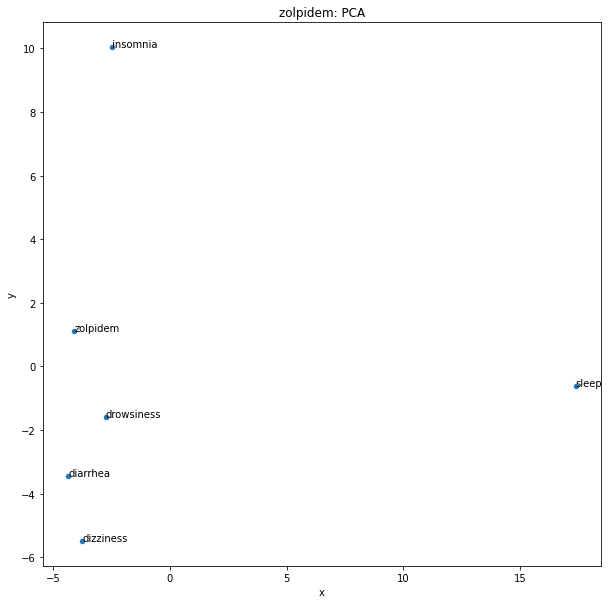

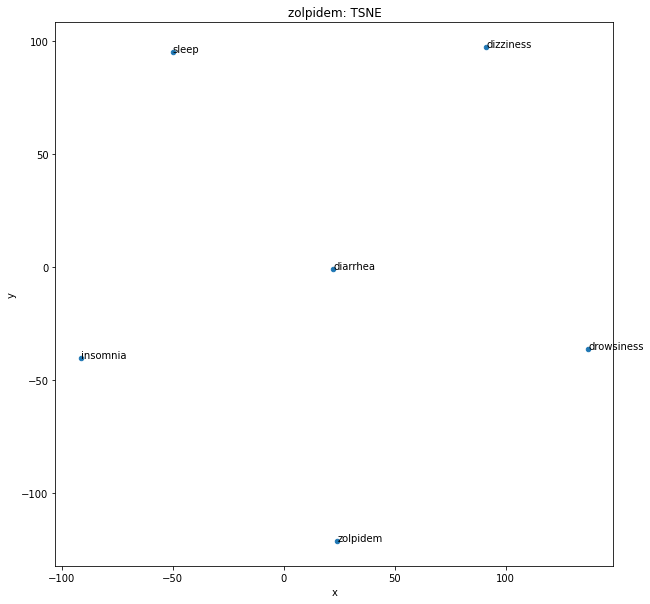

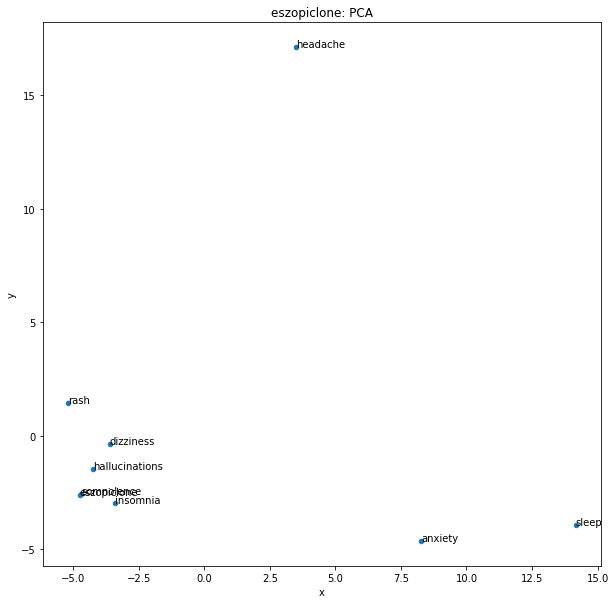

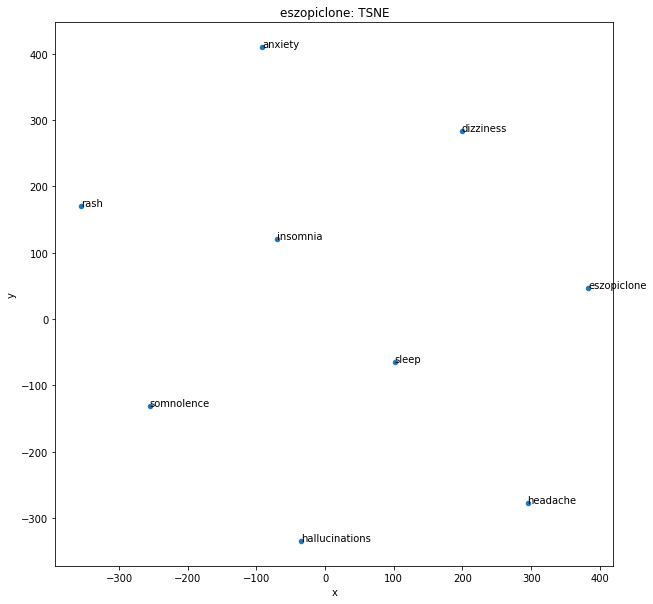

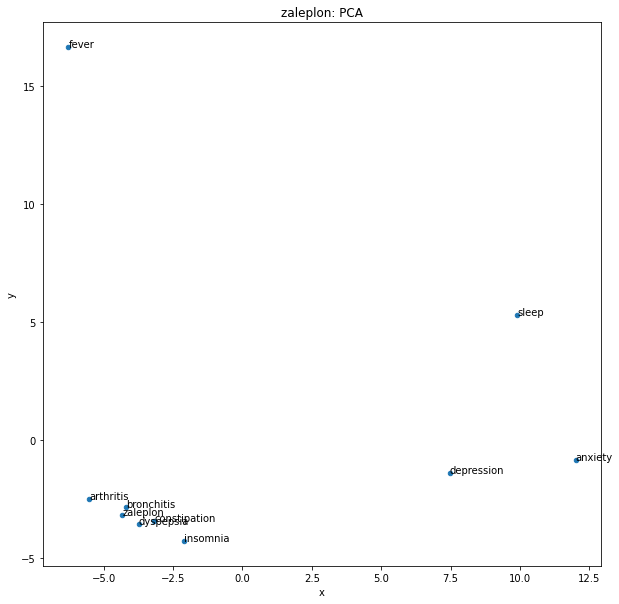

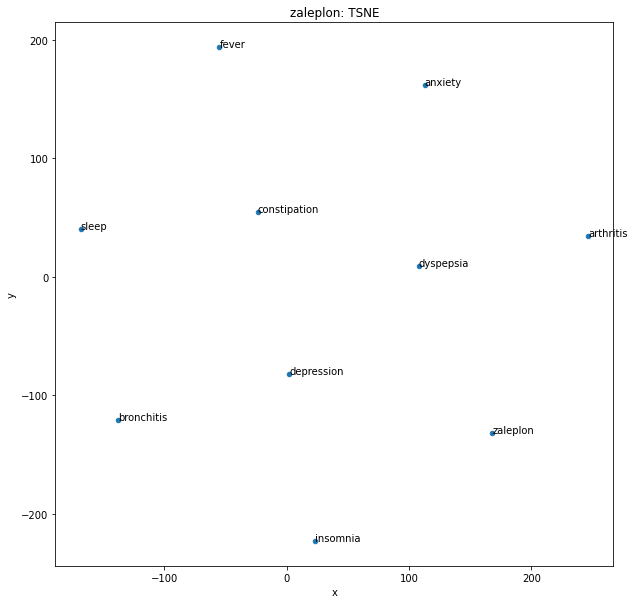

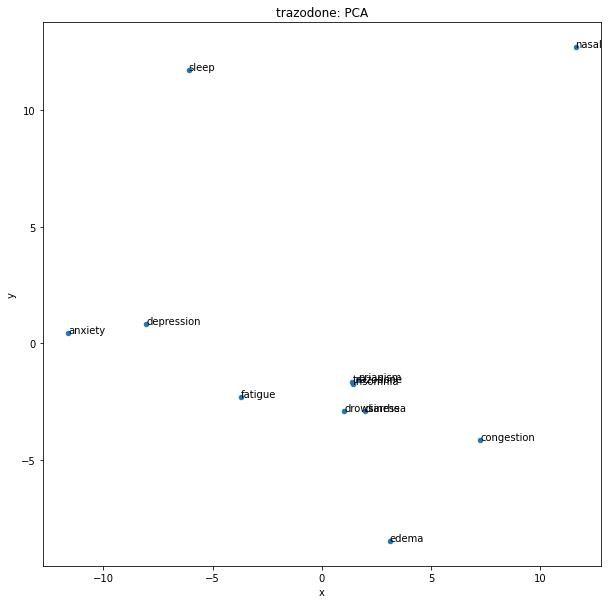

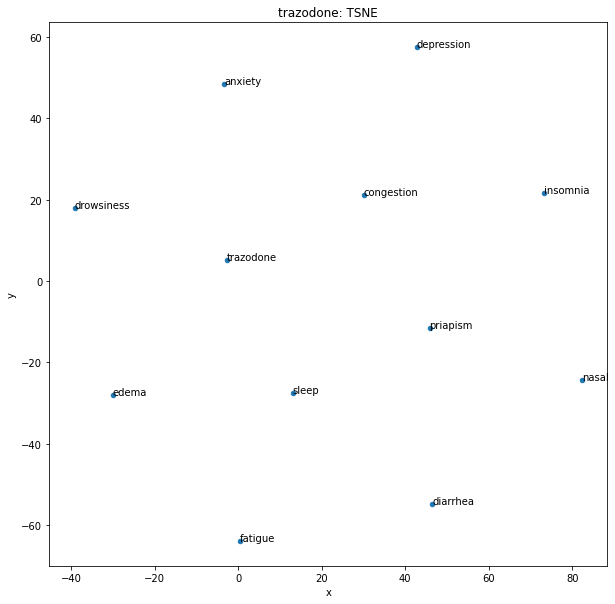

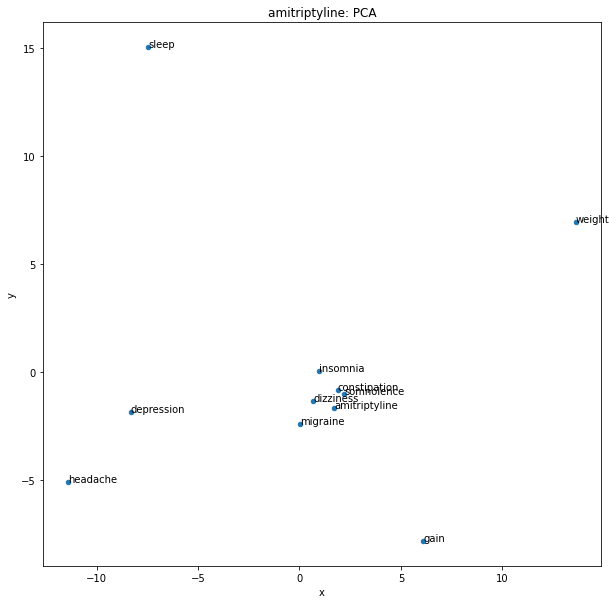

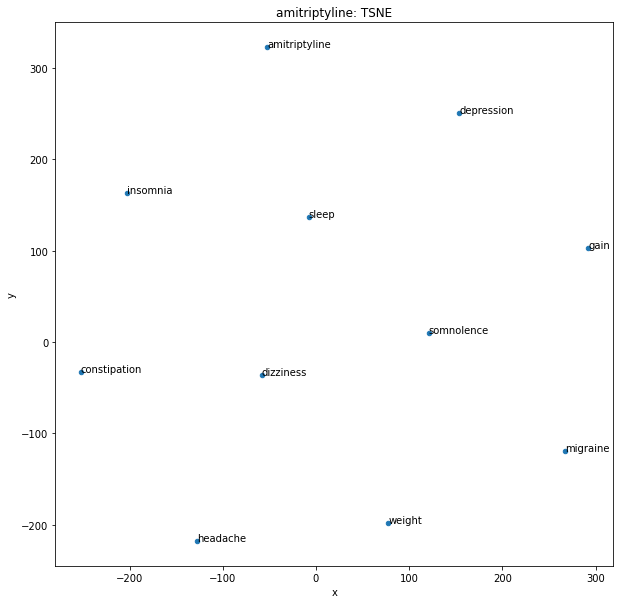

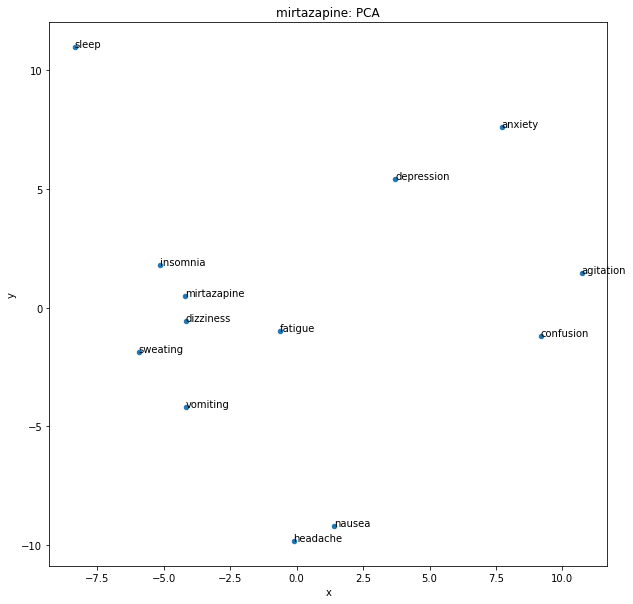

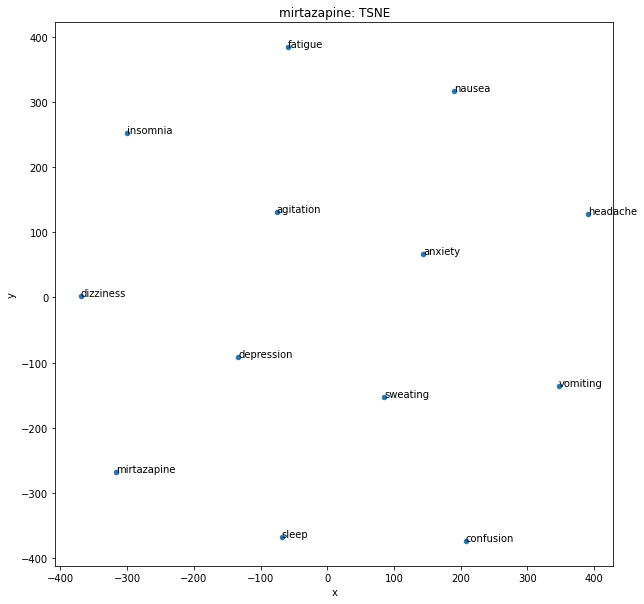

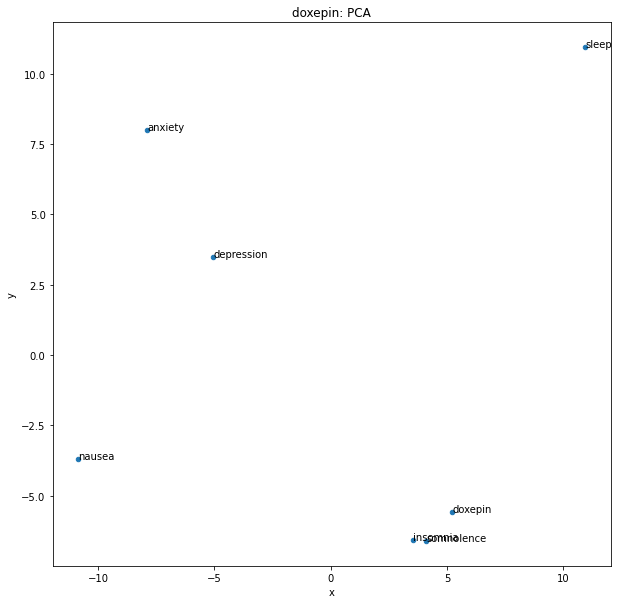

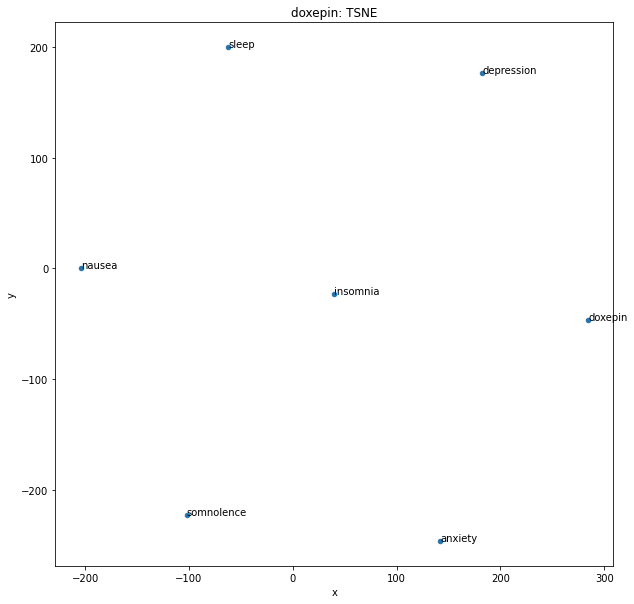

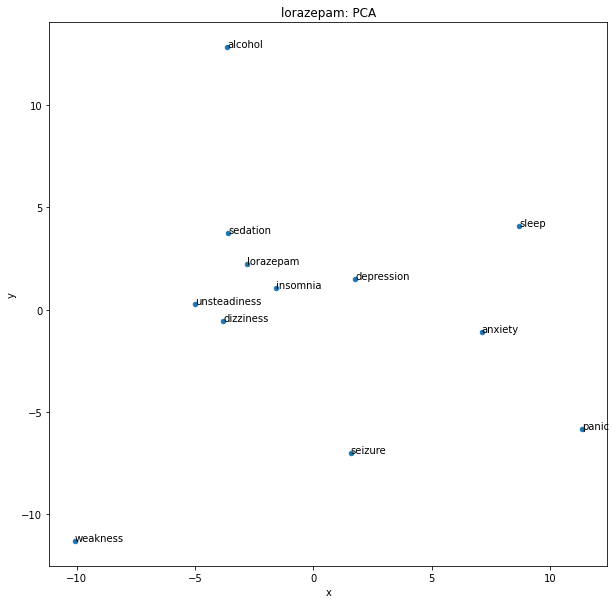

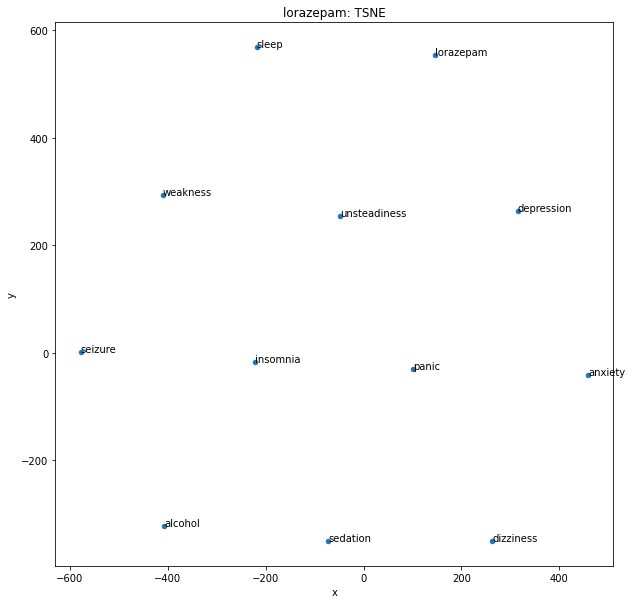

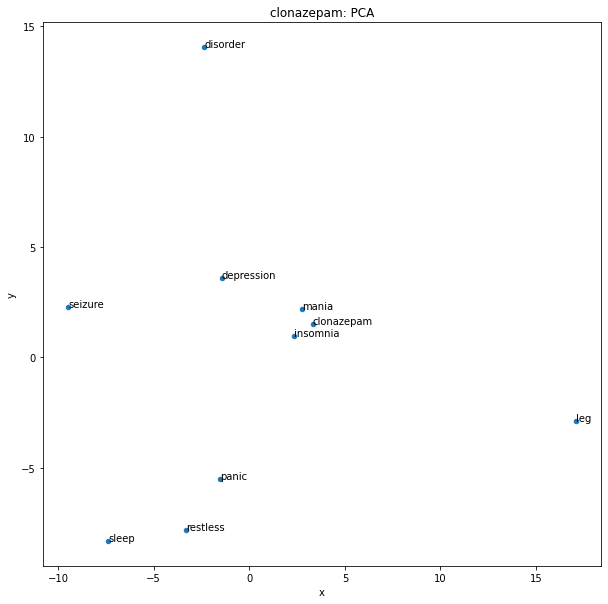

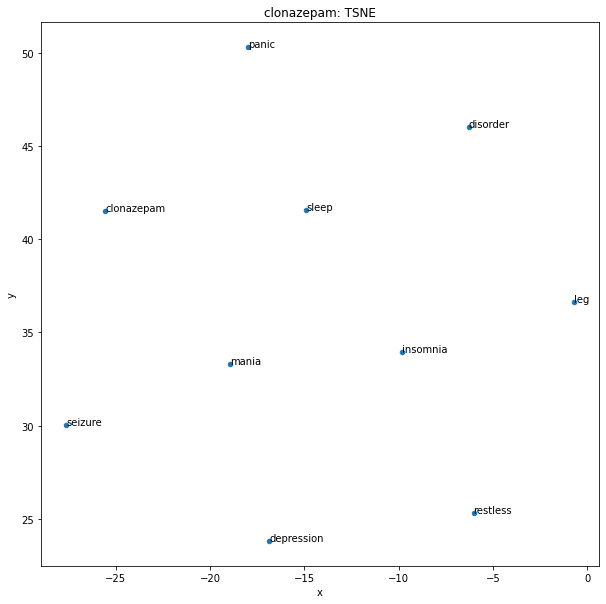

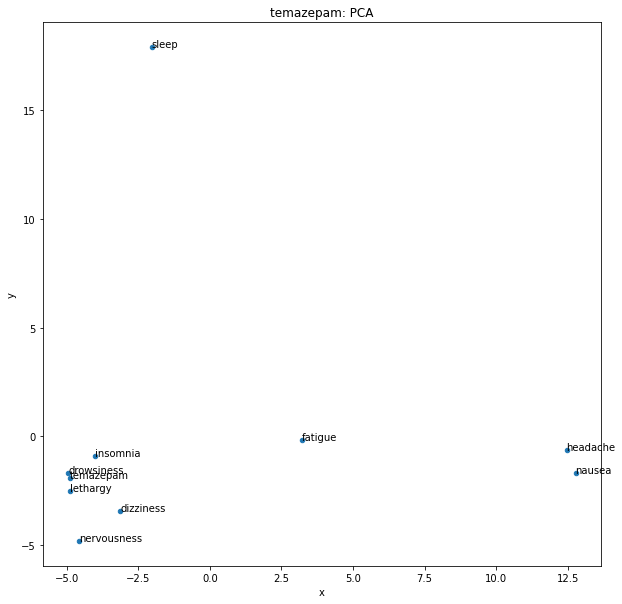

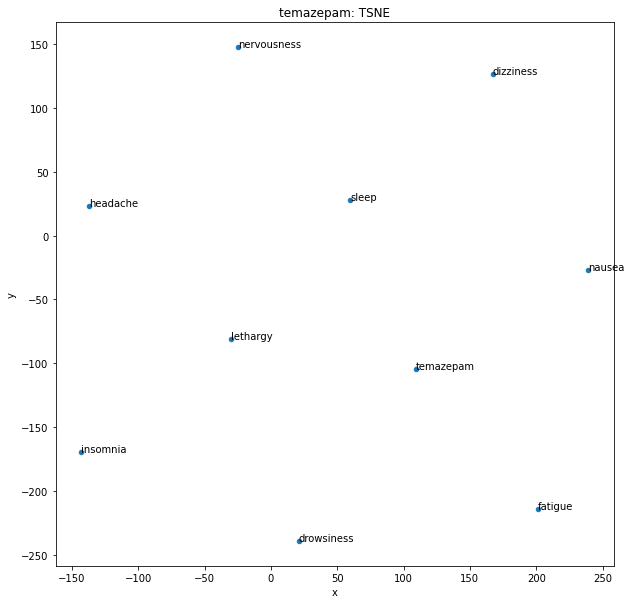

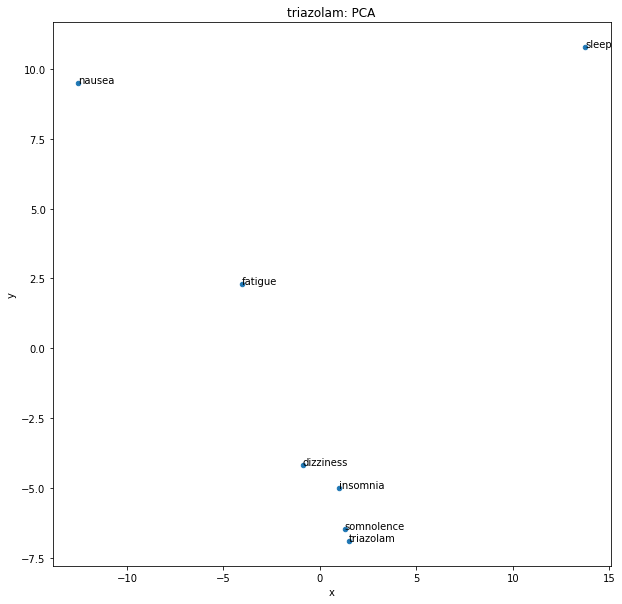

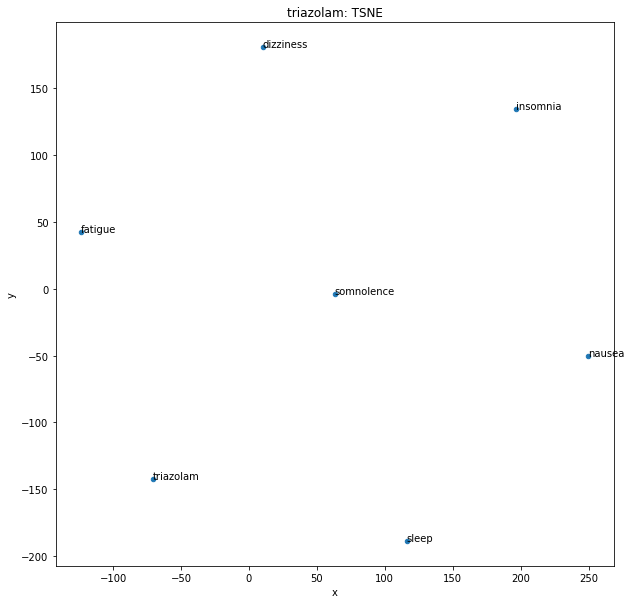

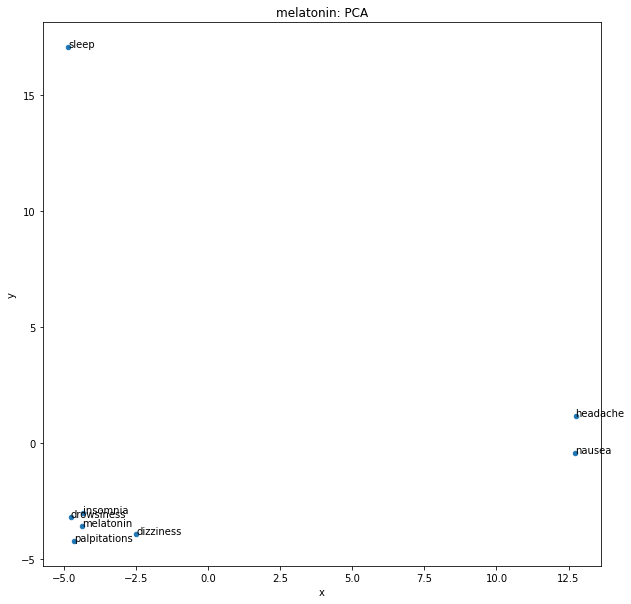

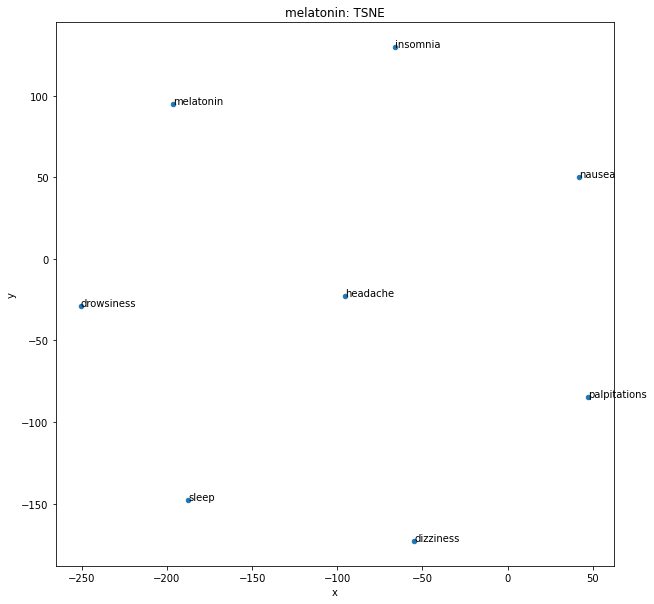

In [32]:
plot_insomnia_drugs()

drowsy
drowse
drowsier
dizzy
dizzying
depressed
depresses
depressing
depressions
depressive
fatigued
fatiguing
anxieties
anxious
anxiously
nauseated
nauseating
nauseous
sleepier
sleepiness
sleeping
sleeps
sleepy
insomniac
insomniacs
feverish
fevers
vomit
vomited
sedate
sedated
weak
weaken
weakened
weakening
weakens
weaker
weakest


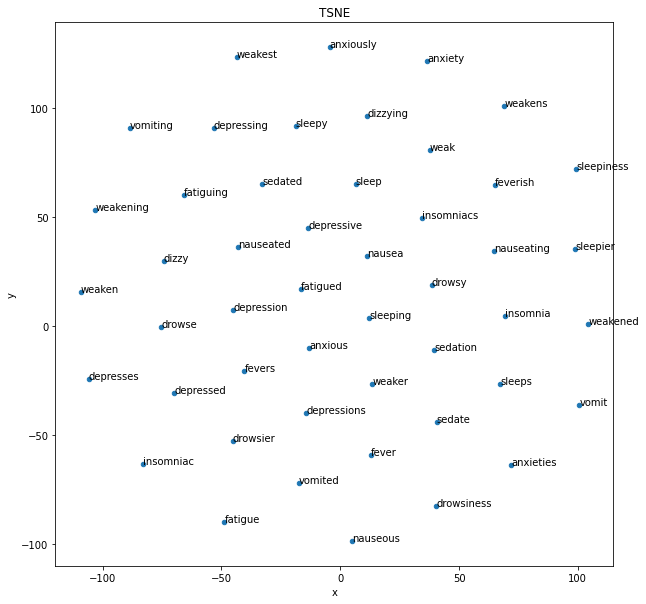

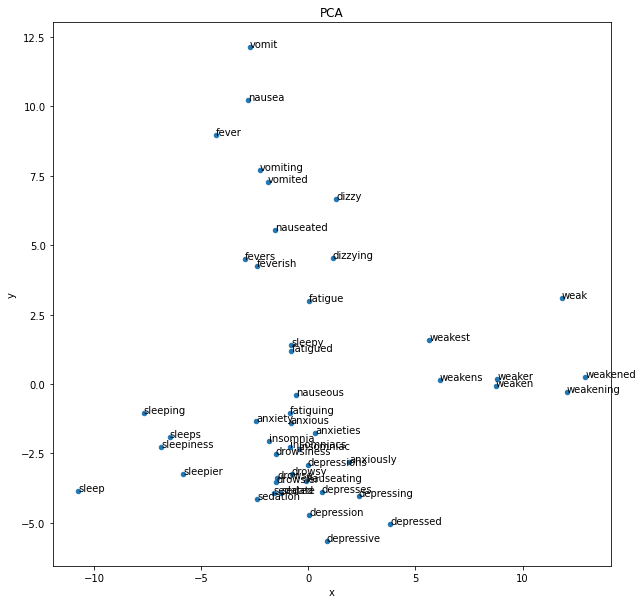

In [36]:
forms_of_words_analysis()

In [15]:
run_eval()

disorder
disease
tumor
neoplasm
disability
vasculature
assessment
evaluation
likelihood
probability
injection
shot
adhesion
attachment
deviation
displacement
activation
risk
disorientation
nutrition
solution
vector
abundance
worm
replication
doubling
intercourse
sex
eye
globe
vaccination
immunization
infiltration
neonate
vessel
vascularity
excision
removal
physician
doctor
obesity
adiposity
coefficient
distention
ethanol
protection
daughter
etiology
susceptibility
predisposition
prophylaxis
prevention
diathesis
adherence
classification
invasion
SpearmanrResult(correlation=0.5646021336400828, pvalue=0.0014194798524525233)
localize
regulate
calibrate
treat
arrest
inhibit
await
equalize
initiate
occur
dissect
stain
block
restrain
label
probe
destabilize
promote
contract
passage
excise
extract
double
replicate
survive
void
suppress
dampen
disclose
study
accumulate
collapse
regain
dilute
ligate
fruit
seed
adhere
attach
coagulate
digest
SpearmanrResult(correlation=0.23099787235415867, pvalue